## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value']=df_comp.ftse

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [5]:
import warnings
warnings.filterwarnings("ignore")

## The LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

## Creating Squared Returns

In [8]:
df['sq_returns'] = df.returns.mul(df.returns)

## Returns vs Squared Returns

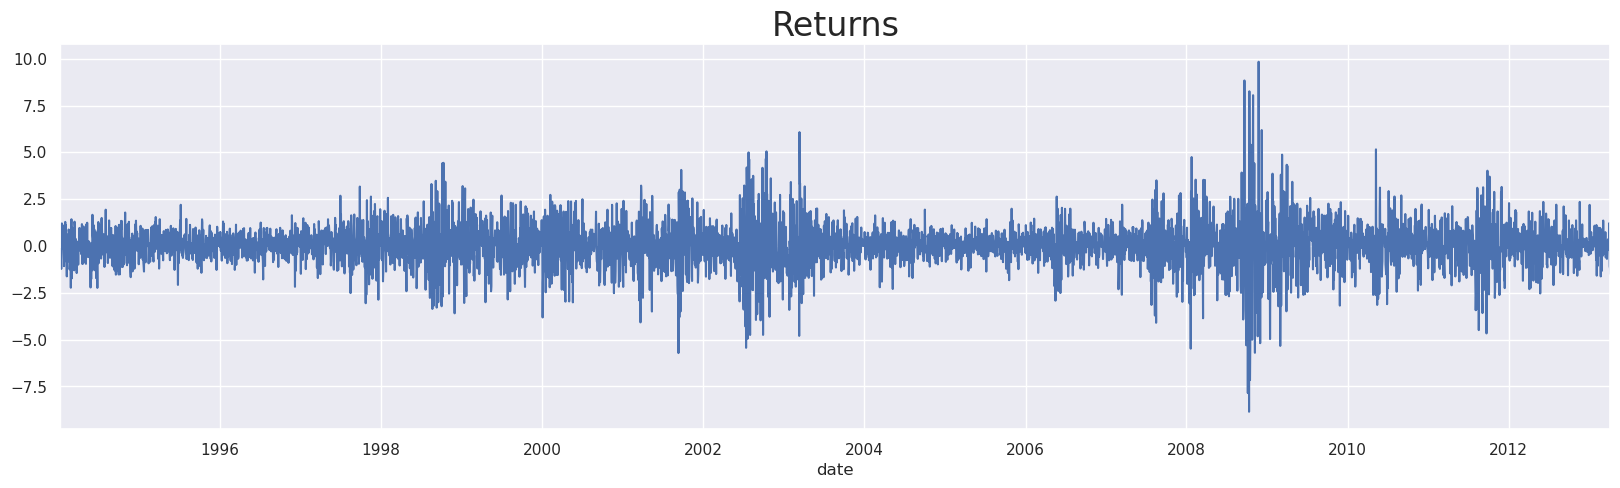

In [9]:
df.returns.plot(figsize=(20,5))
plt.title("Returns", size = 24)
plt.show()

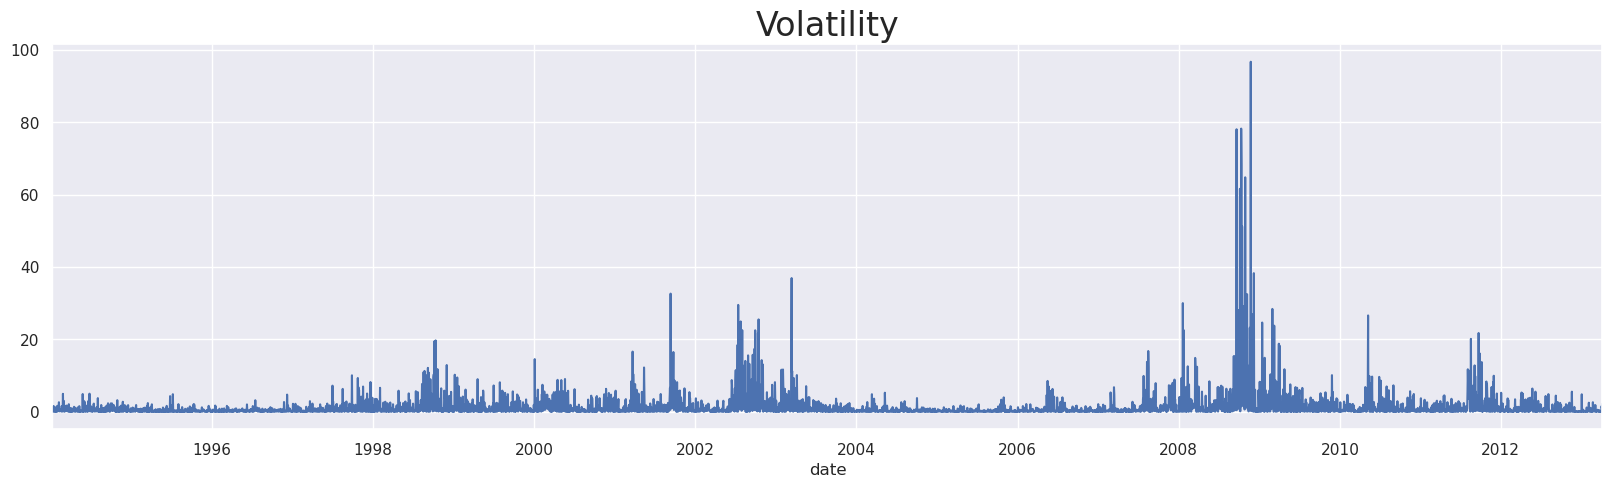

In [10]:
df.sq_returns.plot(figsize=(20,5))
plt.title("Volatility", size = 24)
plt.show()

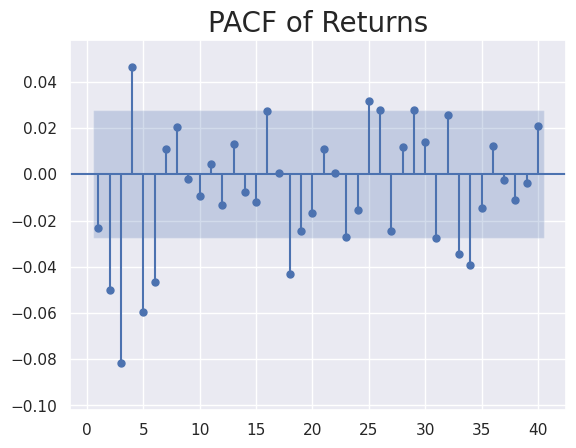

In [11]:
sgt.plot_pacf(df.returns[1:], lags = 40, alpha = 0.05,auto_ylims=True ,zero = False , method = ('ols'))
plt.title("PACF of Returns", size = 20)
plt.show()

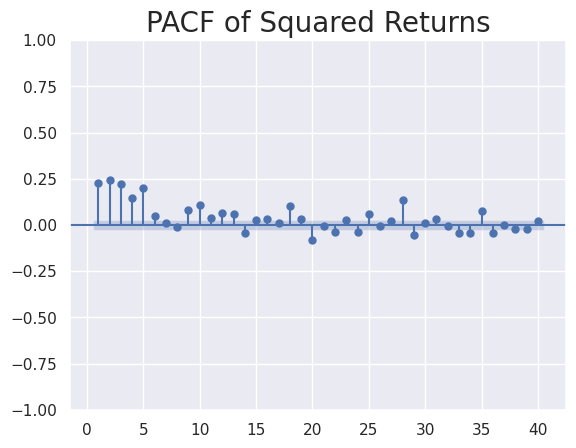

In [12]:
sgt.plot_pacf(df.sq_returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Squared Returns", size = 20)
plt.show()

we can see that the first 6 lags are significant, which suggest there might be some short term trends in variance., that's exactly what volatility represents, high variation => high volatiliy, low variation => low volatility

## The arch_model() Method

In [13]:
from arch import arch_model

In [14]:
model_arch_1 = arch_model(df.returns[1:])
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 7010.712866814991
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.058478417896
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6970.058366189888
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Wed, Apr 05 2023   Df Residuals:                     5019
Time:                        12:09:43   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

## The Simple ARCH(1) 

In [15]:
model_arch_1 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 1) 
#mean=constant so that the model assumes the mean isn't serially correlated
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     30,   Neg. LLF: 7660.088782040875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7660.088782040875
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Wed, Apr 05 2023   Df Residuals:                     5019
Time:                        12:10:34   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

In [16]:
model_arch_1 = arch_model(df.returns[1:], mean = "AR", lags = [2, 3, 6], vol = "ARCH", p = 1, dist = "ged")
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     52,   Neg. LLF: 17360042.957423188
Iteration:     10,   Func. Count:    100,   Neg. LLF: 7326.620988371529
Iteration:     15,   Func. Count:    142,   Neg. LLF: 7317.121042603119
Iteration:     20,   Func. Count:    186,   Neg. LLF: 7317.118105548381
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7317.118092656628
            Iterations: 22
            Function evaluations: 206
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                            returns   R-squared:                       0.008
Mean Model:                                    AR   Adj. R-squared:                  0.007
Vol Model:                                   ARCH   Log-Likelihood:               -7317.12
Distribution:      Generalized Error Distribution   AIC:                           14648.2
Method:                        Maximum Likelihood   BIC:                           14693.9
                                                    No. Observations:                 5014
Date:                            Wed, Apr 05 2023   Df Residuals:                     5010
Time:                                    12:38:15   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0474  6.119e-03      7.748  9.346e-15   [3.542e-02,5.940e-02]
returns[2]    -0.0396  2.806e-02     -1.410      0.158  [-9.456e-02,1.542e-02]
returns[3]    -0.0348  5.925e-03     -5.869  4.372e-09 [-4.639e-02,-2.316e-02]
returns[6]    -0.0283  1.726e-03    -16.407  1.692e-60 [-3.170e-02,-2.494e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9166  3.760e-02     24.378 2.941e-131 [  0.843,  0.990]
alpha[1]       0.3428  3.939e-02      8.703  3.227e-18 [  0.266,  0.420]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0675  3.251e-02     32.842 1.464e-236 [  1.004,  1.131]
========================================================================

Covariance estimator: robust
"""

## Higher-Lag ARCH Models

In [17]:
model_arch_2 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_2 = model_arch_2.fit(update_freq = 5)
results_arch_2.summary()

Iteration:      5,   Func. Count:     37,   Neg. LLF: 8810.02930517937
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7449.545164098316
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7449.55
Distribution:                  Normal   AIC:                           14907.1
Method:            Maximum Likelihood   BIC:                           14933.2
                                        No. Observations:                 5020
Date:                Wed, Apr 05 2023   Df Residuals:                     5019
Time:                        12:42:31   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0484  1.401e-02      3.455  5.495e-04 [2.095e-02,7.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6978  3.564e-02     19.580  2.272e-85 [  0.628,  0.768]
alpha[1]       0.2202  3.474e-02      6.339  2.311e-10 [  0.152,  0.288]
alpha[2]       0.2783  3.645e-02      7.635  2.260e-14 [  0.207,  0.350]
========================================================================

Covariance estimator: robust
"""

In [18]:
model_arch_3 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 3)
results_arch_3 = model_arch_3.fit(update_freq = 5)
results_arch_3.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: 7496.4079308108885
Iteration:     10,   Func. Count:     75,   Neg. LLF: 7277.050452148393
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7277.050452148393
            Iterations: 11
            Function evaluations: 80
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7277.05
Distribution:                  Normal   AIC:                           14564.1
Method:            Maximum Likelihood   BIC:                           14596.7
                                        No. Observations:                 5020
Date:                Wed, Apr 05 2023   Df Residuals:                     5019
Time:                        12:42:37   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0529  1.316e-02      4.018  5.875e-05 [2.707e-02,7.865e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5012  2.834e-02     17.685  5.505e-70 [  0.446,  0.557]
alpha[1]       0.1570  2.649e-02      5.926  3.108e-09 [  0.105,  0.209]
alpha[2]       0.2197  2.588e-02      8.489  2.077e-17 [  0.169,  0.270]
alpha[3]       0.2804  3.354e-02      8.359  6.302e-17 [  0.215,  0.346]
========================================================================

Covariance estimator: robust
"""

In [19]:
model_arch_13 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 13)
results_arch_13 = model_arch_13.fit(update_freq = 5)
results_arch_13.summary()

Iteration:      5,   Func. Count:     89,   Neg. LLF: 10011.775468928608
Iteration:     10,   Func. Count:    179,   Neg. LLF: 7470.895326223472
Iteration:     15,   Func. Count:    269,   Neg. LLF: 7087.895295199729
Iteration:     20,   Func. Count:    359,   Neg. LLF: 7070.0344687053785
Iteration:     25,   Func. Count:    444,   Neg. LLF: 6984.175063672459
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6984.175062617
            Iterations: 27
            Function evaluations: 475
            Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6984.18
Distribution:                  Normal   AIC:                           13998.4
Method:            Maximum Likelihood   BIC:                           14096.2
                                        No. Observations:                 5020
Date:                Wed, Apr 05 2023   Df Residuals:                     5019
Time:                        12:42:42   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0492  1.206e-02      4.077  4.566e-05 [2.553e-02,7.281e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1871  2.210e-02      8.466  2.538e-17      [  0.144,  0.230]
alpha[1]       0.0568  1.729e-02      3.282  1.029e-03  [2.287e-02,9.065e-02]
alpha[2]       0.1156  2.017e-02      5.733  9.840e-09    [7.610e-02,  0.155]
alpha[3]       0.1265  2.625e-02      4.820  1.433e-06    [7.509e-02,  0.178]
alpha[4]       0.0884  2.159e-02      4.093  4.265e-05    [4.605e-02,  0.131]
alpha[5]       0.0695  1.750e-02      3.970  7.189e-05    [3.518e-02,  0.104]
alpha[6]       0.0865  1.926e-02      4.491  7.092e-06    [4.874e-02,  0.124]
alpha[7]       0.0404  1.846e-02      2.188  2.870e-02  [4.203e-03,7.658e-02]
alpha[8]       0.0654  1.833e-02      3.565  3.633e-04    [2.943e-02,  0.101]
alpha[9]       0.0292  1.603e-02      1.820  6.877e-02 [-2.244e-03,6.058e-02]
alpha[10]      0.0335  1.605e-02      2.089  3.670e-02  [2.072e-03,6.498e-02]
alpha[11]      0.0775  1.760e-02      4.403  1.067e-05    [4.300e-02,  0.112]
alpha[12]      0.0473  1.873e-02      2.526  1.153e-02  [1.060e-02,8.402e-02]
alpha[13]      0.0372  1.431e-02      2.600  9.317e-03  [9.162e-03,6.526e-02]
=============================================================================

Covariance estimator: robust
"""